## **P03: Connect 4 Agent (Minimax, Alpha-Beta Pruning)**
*Tijuana, B.C. | 26 MAR 2024*

*Presenta:*
- Agraz Vallejo Daniel
- Cruz Jimenez Axel
- Roldan Machado David

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from classes.players.Player import Player
from classes.players.HumanPlayer import HumanPlayer
from classes.players.SmartComputerPlayer import SmartComputerPlayer
from classes.players.RandomComputerPlayer import RandomComputerPlayer

GAME_DIMS = (6,7)

#### **Support Functions**

In [2]:
def get_fm(img:tuple, f:tuple, stride:np.int8) -> tuple:
    feature_dims = np.empty(2, dtype=np.int8)
    if (((img[0] - f[0]) % stride != 0) or ((img[1] - f[1]) % stride != 0)):
        return "Operation is not valid!"
    else:
        feature_dims[0] = (img[0] - f[0]) / stride + 1
        feature_dims[1] = (img[1] - f[1]) / stride + 1
    return tuple(feature_dims)

#### **Board Class**

In [3]:
# Game.py - Board Class

# Board Graphic display settings (Connect 4)
CONNECT_FOUR_WC = 4
SYMBOL_SIZE = 30
X_SYMBOL = 'X'; X_COLOR = 'b'
O_SYMBOL = 'O'; O_COLOR = 'r'
X_POS = {0: 0.25, 1: 1.21, 2: 2.25, 3:3.21, 4:4.25, 5:5.21, 6:6.25}
Y_POS = {0: 5.25, 1: 4.25, 2: 3.25, 3:2.25, 4:1.25, 5:0.25}

class Board():
    __graph_board : Figure   # Visual representation 
    __s : np.ndarray         # Board state
    __bin: np.ndarray        # Array that contains 0s and 1s count from s
    __history: list          # Stores played moves
    __ply: int               # Number of moves
    __dim: tuple             # Board dimensions


    def __init__(self, dim:tuple) -> Figure:
        self.__s = np.empty(dim, dtype=object)
        self.__graph_board = None
        self.__history = []
        self.__ply = 0
        self.__dim = dim
        self.set_bin()
        self.__init_board()
 
    # BOARD METHODS
    # Board Initialization
    def __init_board(self):
        """
        A helper function to plot Tic-Tac-Toe Board
        """
        plt.ioff()

        # Create a new figure
        self.__graph_board, ax = plt.subplots()
        self.__graph_board.set_facecolor('k')


        # Draw Board
        delta = abs(self.__dim[0] - self.__dim[1])
        for i in range(0, self.__dim[1] - delta):
            ax.plot([0, self.__dim[1]], [i, i], 'w-')

        for j in range(0, self.__dim[0] + delta + 1):
            ax.plot([j, j], [0, self.__dim[0]], 'w-')

        # Set the aspect of the plot to be equal to get a square grid
        ax.set_aspect('equal')

        # Remove axes
        ax.axis('off')
    
    # Resets board
    def init_state(self):
        plt.close('all')
        self.__init__(self.__dim)


    # Visually display current game board
    def update_board(self, u:np.ndarray) -> Figure:
        ax = self.__graph_board.axes[0]
        x, y = u[0], u[1]
        if self.__s[x, y] is not None:
            symbol = X_SYMBOL if self.__s[x, y] == 1 else O_SYMBOL
            color = X_COLOR if symbol == X_SYMBOL else O_COLOR
            ax.text(X_POS[y], Y_POS[x], symbol, fontsize=SYMBOL_SIZE, color=color)


    # IMPLEMENTATION METHODS
        
    # Player(s): Gets the player in turn to play from board state
    def player(self) -> str:
        return 'X' if np.sum(self.__s == 1) <= np.sum(self.__s == 0) else 'O'

    # Actions(s): Get player's actions from given state (SPACE SEARCH U(x))
    def actions(self) -> np.ndarray:
        U = []
        for col in range(self.__dim[1]):
            if (self.__s[:, col] != None).all(): continue
            else: U.append(list([np.where(self.__s[:, col] == None)[0][-1], col]))
            U.append(list([np.where(self.__s[:, col] == None)[0][-1], col]))
        return np.array(U)

    # Result(s, a): Executes board move (TRANSITION FUNCTION f(x,u))
    def make_move(self, x:np.ndarray):
        x = x.flatten()
        if self.__s[x[0], x[1]] is None:
            self.__s[x[0], x[1]] = 1 if self.player() == 'X' else 0
            self.__history.append(x)
            self.__ply += 1
            self.set_bin()
        else:
            print("Invalid Move. Square has been taken.")
    
    # Reverts last move
    def undo_move(self):
        if len(self.history) == 0:
            pass
        else:
            self.__s[self.history[-1][0], self.history[-1][1]] = None
            self.__ply -= 1

    # Terminal(s): From current board state, indicates if the board has a winner or draw
    def is_terminal(self) -> bool:
        winner = self.winner()
        if winner == None or winner: 
            return True
        else: return False

    # Winner(s): Given current game state return the game's outcome
    def winner(self):
        self.undo_move()
        prospect_winner = self.player()
        if len(self.history) > 0: self.make_move(self.history[-1]); self.history.pop()
        win_struct = np.ones((1, CONNECT_FOUR_WC)) if prospect_winner == 'X' else np.zeros((1, CONNECT_FOUR_WC))
        
        # Check winner by Rows
        for i in range(self.__s.shape[0]):
            x = 0
            for val in self.__s[i,:]:
                if val == win_struct[0,0]: x += 1
                else: x = 0
                if x >= CONNECT_FOUR_WC: return prospect_winner
        
        # Check winner by Columns
        for j in range(self.__s.shape[1]):
            x = 0
            for val in self.__s[:,j].T:
                if val == win_struct[0,0]: x += 1
                else: x = 0
                if x >= CONNECT_FOUR_WC: return prospect_winner
            
        # Check winner by Diagonals
        fm = get_fm(self.__dim, (CONNECT_FOUR_WC, CONNECT_FOUR_WC), 1)

        for i in range(fm[0]):
            for j in range(fm[1]):
                s = self.__s[i:fm[1]+i, j:fm[1]+j]
                if (np.isin(np.diag(s), win_struct).all() or (np.fliplr(s).diagonal() == win_struct).all()):
                    return prospect_winner
            
        if np.sum(self.__bin) == np.prod(self.__s.shape): return None
        return False
    
    # Utility(s): Returns board evaluation given a terminal state
    def utility(self):
        if self.is_terminal():
            winner = self.winner()
            if winner == None: return 0
            return 1 if winner == 'X' else -1
        else:
            return False


    # GETTERS
    @property
    def board(self) -> Figure:
        return self.__graph_board
    
    @property
    def state(self) -> np.ndarray:
        return self.__s
            
    @property
    def history(self) -> list:
        return self.__history
    
    @property
    def ply(self) -> int:
        return self.__ply
    
    # SETTERS
    def set_state(self, s:np.ndarray):
        self.__s = s
        self.set_bin()

    def set_bin(self):
        self.__bin = np.bincount(self.__s[(self.__s != None)].astype(np.int8))

#### **Minimax Algorithm**

In [4]:
def minimax(board:Board, depth:int) -> tuple:
    if board.is_terminal() or depth == 0:
        return board.utility(), None

    best_value = -math.inf if board.player() == 'X' else math.inf
    best_move = None

    for move in board.actions():
        board.make_move(move)
        val, _ = minimax(copy.deepcopy(board), depth - 1)
        board.undo_move()

        if board.player() == 'X':
            if val > best_value:
                best_value = val
                best_move = move
        else:
            if val < best_value:
                best_value = val
                best_move = move

    return best_value, best_move

#### **Alfa-Beta Pruning Algorithm**

In [5]:
def alfabeta(board:Board, depth:np.int8, alpha, beta) -> tuple:
    a = alpha; b = beta

    if board.is_terminal() or depth == 0:
        return board.utility(), None

    best_value = -math.inf if board.player() == 'X' else math.inf
    best_move = None

    for move in board.actions():
        board.make_move(move)
        val, _ = alfabeta(copy.deepcopy(board), depth - 1, alpha, beta)
        board.undo_move()

        if board.player() == 'X':
            if val > best_value:
                best_value = val
                best_move = move
            a = np.maximum(a, val)
            if a >= b: break
        else:
            if val < best_value:
                best_value = val
                best_move = move
            b = np.minimum(b, val)
            if a >= b: break
    return best_value, best_move

In [6]:
def get_feature_map(img:tuple, f:tuple, stride:np.int8) -> tuple:
    feature_dims = np.empty(2, dtype=np.int8)
    if (((img[0] - f[0]) % stride != 0) or ((img[1] - f[1]) % stride != 0)):
        return "Operation is not valid!"
    else:
        feature_dims[0] = (img[0] - f[0]) / stride + 1
        feature_dims[1] = (img[1] - f[1]) / stride + 1
    return tuple(feature_dims)

#### **P1.1:** Implementar el juego Conecta 4 de forma completa empleando las funciones que se especifican en **P1.3**

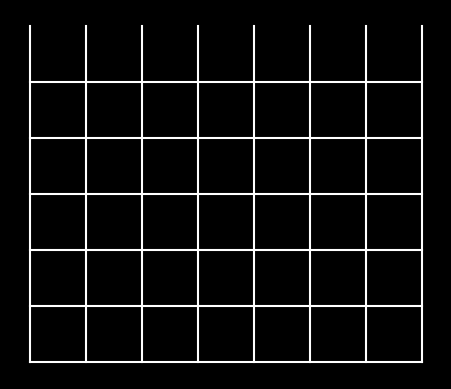

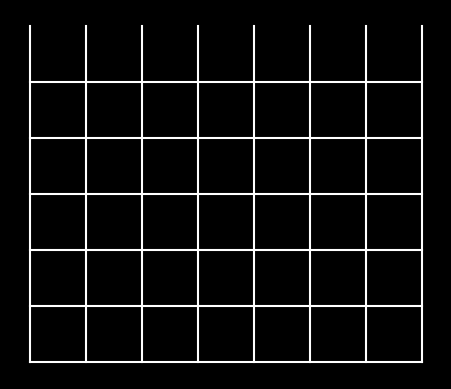

In [7]:
b = Board((6,7))
b.board

In [8]:
b.init_state()

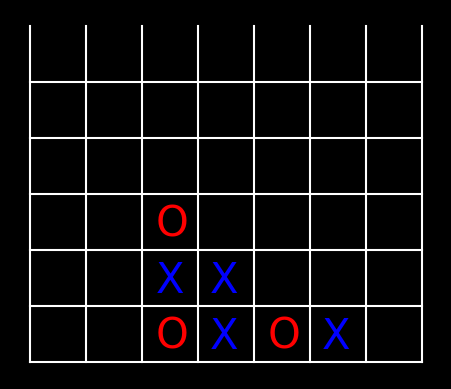

In [9]:
b.make_move(np.array([5,5])); b.update_board(np.array([5,5]))
b.make_move(np.array([5,2])); b.update_board(np.array([5,2]))
b.make_move(np.array([5,3])); b.update_board(np.array([5,3]))
b.make_move(np.array([5,4])); b.update_board(np.array([5,4]))
b.make_move(np.array([4,2])); b.update_board(np.array([4,2]))
b.make_move(np.array([3,2])); b.update_board(np.array([3,2]))
b.make_move(np.array([4,3])); b.update_board(np.array([4,3]))
display(b.board)

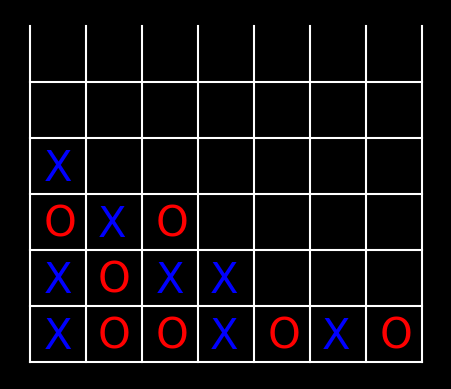

In [10]:
b.make_move(np.array([5,1])); b.update_board(np.array([5,1]))
b.make_move(np.array([5,0])); b.update_board(np.array([5,0]))
b.make_move(np.array([4,1])); b.update_board(np.array([4,1]))
b.make_move(np.array([3,1])); b.update_board(np.array([3,1]))
b.make_move(np.array([5,6])); b.update_board(np.array([5,6]))
b.make_move(np.array([4,0])); b.update_board(np.array([4,0]))
b.make_move(np.array([3,0])); b.update_board(np.array([3,0]))
b.make_move(np.array([2,0])); b.update_board(np.array([2,0]))
display(b.board)

In [11]:
b.state

array([[None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None],
       [1, None, None, None, None, None, None],
       [0, 1, 0, None, None, None, None],
       [1, 0, 1, 1, None, None, None],
       [1, 0, 0, 1, 0, 1, 0]], dtype=object)

In [12]:
b.winner()

'X'

#### **P1.2:** La dinámica del juego es la siguiente:  

a) El usuario selecciona $\text{'X'}$ u $\text{'O'}$

b) Siempre inicia el juego $\text{'X'}$ (MAX)

c) Llevar a cabo el juego entre agente y usuario.

d) Desplegar el estado de juego a cada paso (movimiento).

e) Desplegar resultado final (ganador o empate).

##### **Implementación de Juego**

In [13]:
def play(game:Board, x_player:Player, o_player:Player) -> None:
    while (np.any(game.state == None) and not game.is_terminal()):
        # Gets Player X/O move
        move = x_player.get_move(game) if game.player() == 'X' else o_player.get_move(game)
        game.make_move(move)
    
        print(f"{game.state}\n")
        game.update_board(move)
        display(game.board)
    winner = game.winner()
    if winner == 'X': print(f"PLAYER {x_player.letter} HAS WON!!")
    elif winner == 'O': print(f"PLAYER {o_player.letter} HAS WON!!")
    else: print(f"GAME ENDED IN A DRAW!")
    game.init_state()

In [14]:
t.init_state()

NameError: name 't' is not defined

Welcome to Connect 4!!
Minimax played: [5 0]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 2954
RECURSIONS MADE: 210
[[None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [1 None None None None None None]]



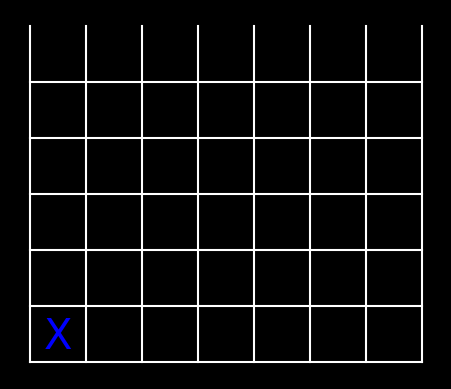

[[None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [1 0 None None None None None]]



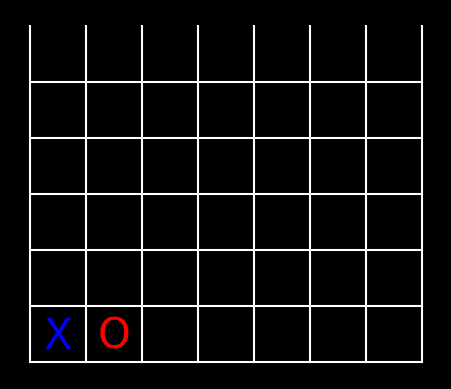

Minimax played: [4 0]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 2954
RECURSIONS MADE: 210
[[None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [1 None None None None None None]
 [1 0 None None None None None]]



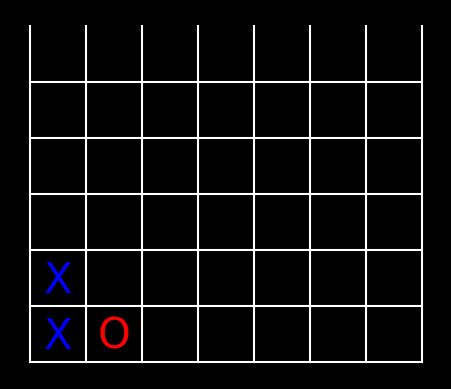

[[None None None None None None None]
 [None None None None None None None]
 [None None None None None None None]
 [0 None None None None None None]
 [1 None None None None None None]
 [1 0 None None None None None]]



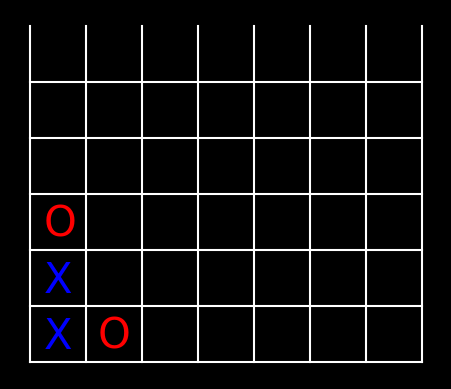

Minimax played: [2 0]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 2954
RECURSIONS MADE: 210
[[None None None None None None None]
 [None None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 None None None None None None]
 [1 0 None None None None None]]



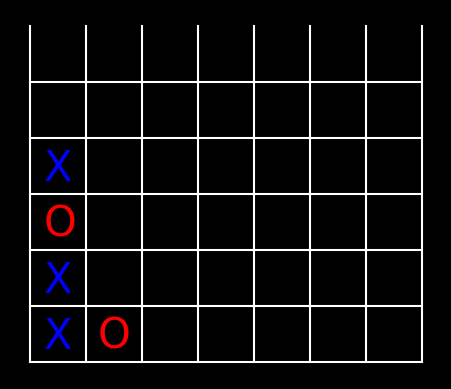

[[None None None None None None None]
 [None None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 None None None None None]]



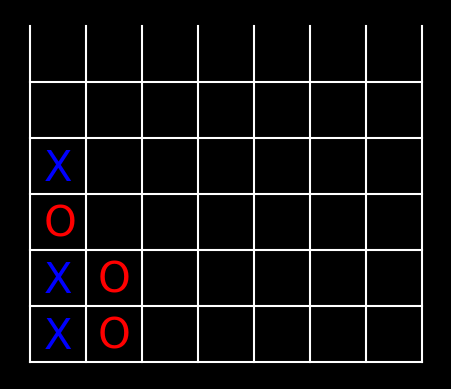

Minimax played: [1 0]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 2946
RECURSIONS MADE: 210
[[None None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 None None None None None]]



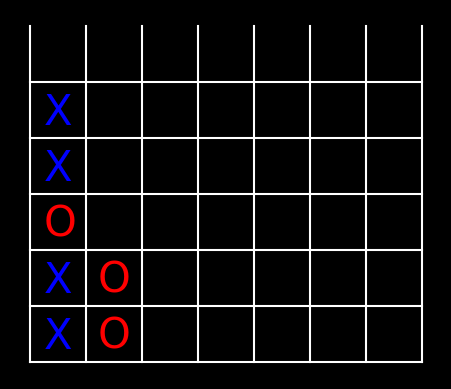

[[None None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 0 None None None None]]



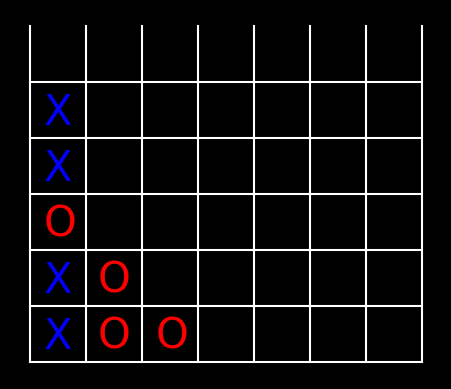

Minimax played: [0 0]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 2798
RECURSIONS MADE: 206
[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 0 None None None None]]



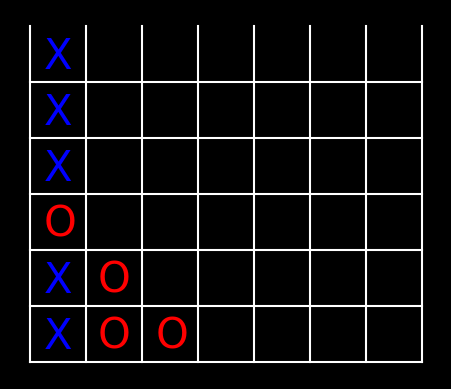

[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 0 0 None None None]]



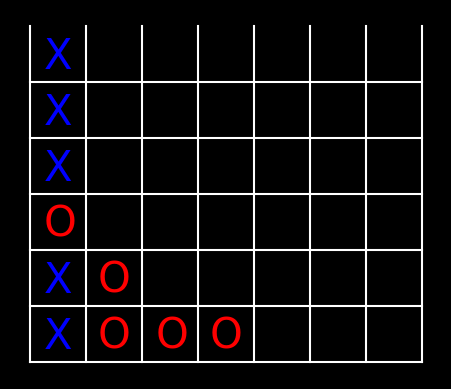

Minimax played: [5 4]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 1644
RECURSIONS MADE: 136
[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None None None None]
 [1 0 0 0 1 None None]]



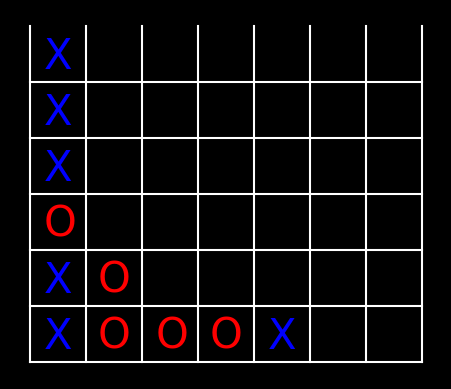

[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 None None None None None None]
 [1 0 None None 0 None None]
 [1 0 0 0 1 None None]]



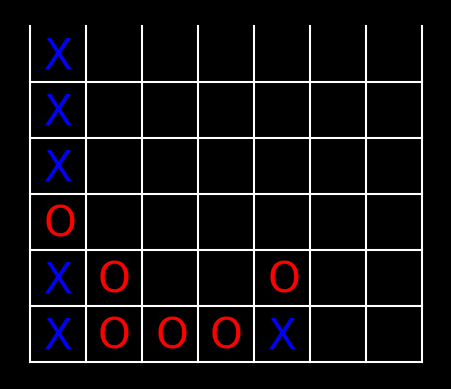

Minimax played: [3 1]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 1884
RECURSIONS MADE: 156
[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 1 None None None None None]
 [1 0 None None 0 None None]
 [1 0 0 0 1 None None]]



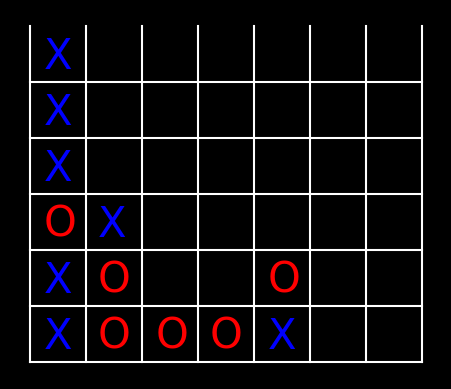

[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 1 None None None None None]
 [1 0 None 0 0 None None]
 [1 0 0 0 1 None None]]



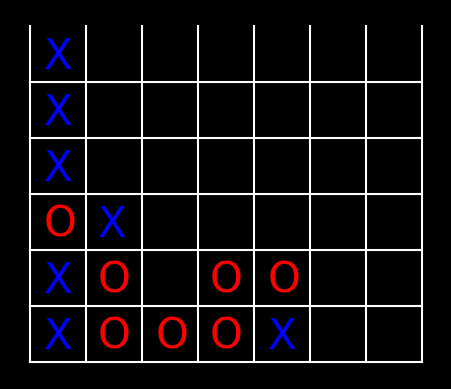

Minimax played: [4 2]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 1644
RECURSIONS MADE: 136
[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 1 None None None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



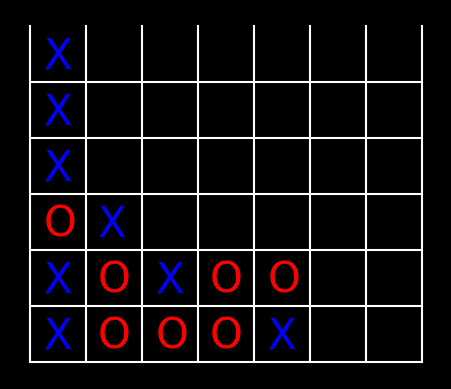

[[1 None None None None None None]
 [1 None None None None None None]
 [1 None None None None None None]
 [0 1 0 None None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



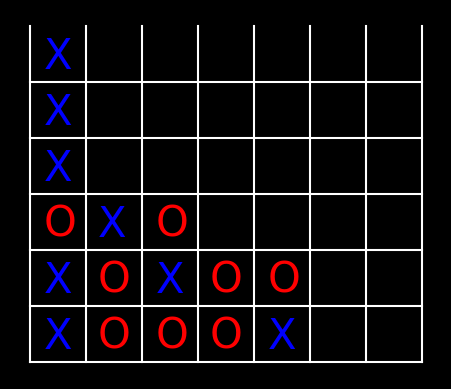

Minimax played: [2 1]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 1884
RECURSIONS MADE: 156
[[1 None None None None None None]
 [1 None None None None None None]
 [1 1 None None None None None]
 [0 1 0 None None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



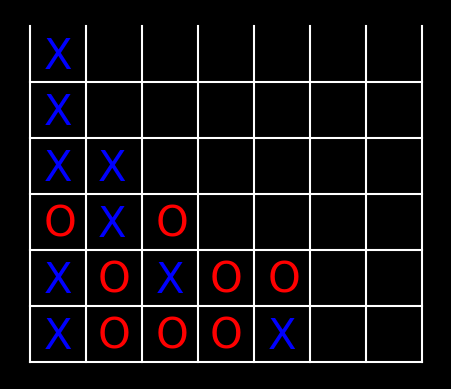

[[1 None None None None None None]
 [1 0 None None None None None]
 [1 1 None None None None None]
 [0 1 0 None None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



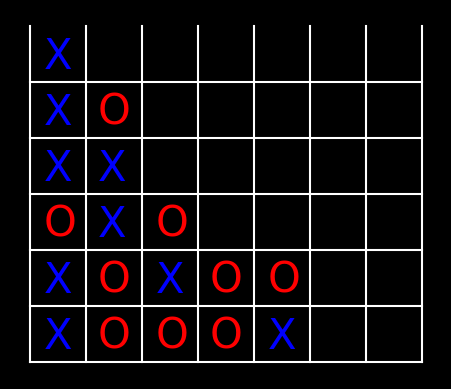

Minimax played: [0 1]

Move Utility: False

ITERATIONS TO FIND BEST MOVE: 1752
RECURSIONS MADE: 152
[[1 1 None None None None None]
 [1 0 None None None None None]
 [1 1 None None None None None]
 [0 1 0 None None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



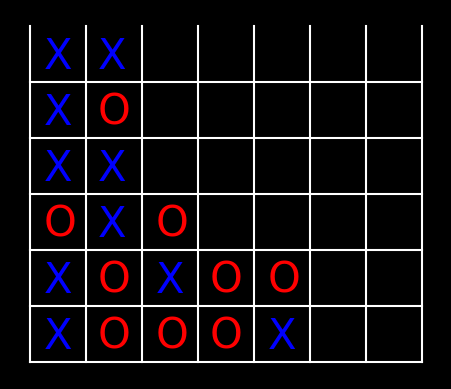

[[1 1 None None None None None]
 [1 0 None None None None None]
 [1 1 None None None None None]
 [0 1 0 0 None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



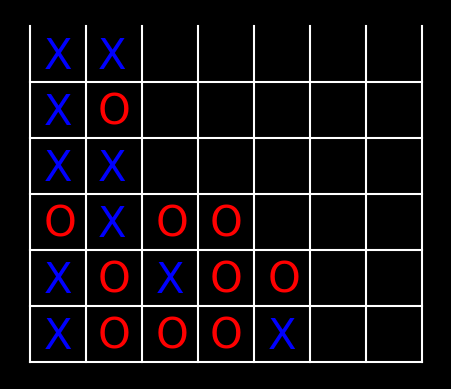

Minimax played: [2 2]

Move Utility: -1

ITERATIONS TO FIND BEST MOVE: 790
RECURSIONS MADE: 78
[[1 1 None None None None None]
 [1 0 None None None None None]
 [1 1 1 None None None None]
 [0 1 0 0 None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



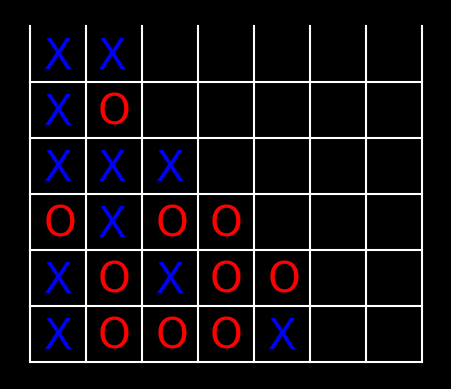

[[1 1 None None None None None]
 [1 0 None None None None None]
 [1 1 1 0 None None None]
 [0 1 0 0 None None None]
 [1 0 1 0 0 None None]
 [1 0 0 0 1 None None]]



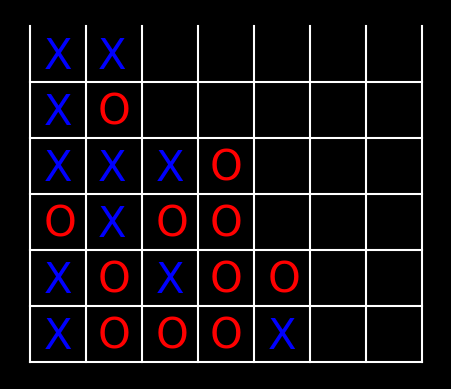

PLAYER O HAS WON!!


In [15]:
print("Welcome to Connect 4!!")
human_player = input("Select your Player X/O: ")
t = Board(GAME_DIMS)
x_player = HumanPlayer('X') if human_player == 'X' else SmartComputerPlayer('X')
o_player = HumanPlayer('O') if human_player == 'O' else SmartComputerPlayer('O')
# x_player = RandomComputerPlayer('X')
# o_player = RandomComputerPlayer('O')

play(t, x_player, o_player)

`initial_state()`: el estado inicial, $S_{0}$, especifica la configuración  
inicial del juego (en nuestro caso, un tablero vacío de $6 \times 7$).

`display(s)`: función para desplegar la inforamción del tablero  
(estado actual) en forma gráfica utilizando: Matplotlib, Pygame, Tkinter, OpenCV.

`player(s)`: regresa a que jugador ($X\;\text{u}\;O$) le toca mover dado el estado `s`.

`actions(s)`: regresa un conjunto de acciones legales (qué lugares   
están libres en el tablero) dado el estado `s`.

`result(s,a)`: el modelo de transición, función que regresa  
el estado reusltante de tomar la acción `a` en el estado `s`.

`terminal(s)`: la prueba de terminación es verdadera (`True`) cuando el  
juego termina (es decir, verificar si alguien ganó o hay empate) y es   
falsa (`False`) en caso contrario. El estado `s` donde termina el juego   
es llamado estado terminal.

`utility(s)`: la función de utilidad (también llamada función objetivo)  
define el valor numérico final para el jugador cuando el juego terminal  
en el estado terminal `s`. Devuelve el valor de utilidad del estado: -1, 0 o 1.

`minimax(s)`: Optimizado con `alpha-beta pruning`, función que regresa  
el valor (movimiento)óptimo dependiendo a que jugador $(X \;\text{u} \; O)$   
le toca mover el estado.  

#### **P1.3:** Implementar las siguientes funciones del agente: